# Example 1 - Analyze RNA-seq Data

## Introduction
This code is designed to handle RNA-seq data that has been pre-processed to the point where gene names, fold change, and statistical analyses have been determined.  
The input data, which will be processed using the `Cleaner` class, is an `.xlsx` table with the following mandatory columns:

- **row** (gene name)
- **log2FoldChange**
- **padj**

<div style="border: 1px solid red; padding: 10px; background-color: #f8d7da; color: #721c24; border-radius: 5px;">
    <strong>Alert:</strong> It's important to note that while additional columns may exist in the file, these three columns are mandatory.
</div>

## background

This project aims to identify pathways or key genes regulated by HOXD8 and affect tumor
aggressiveness.

HOXD8, a transcription factor involved in embryonic development is overexpressed in
glioblastoma (GBM). Knockdown of HOXD8 reduced the proliferation of GBM cells in vitro and
prolonged the survival of mice. Additional analysis of the tumor identified significant
differences in the immune microenvironment of the tumors.
Changes in RNA-seq between control and knockdown tumors is used to investigate the pathways in which HOXD8 affects the
aggressiveness of this tumor.

**Raw data**

The data comprises of DESeq2 analysis results.
DESeq2 is a statistical method used for analyzing count data from RNA sequencing experiments to identify differentially expressed genes (DEGs).
the provided data is a list of genes with associated statistics, such as log2 fold changes, p-values, and adjusted p-values, indicating the significance of differential expression between the experimental conditions, in this case HOXD8 KO and WT tumors.

## Cleaner class
The `Cleaner` class goal is to clean NaN values that exist in the raw data, and to remove undesired rows (that is, rows that the reading is not statistically significant).
First, lets view the raw data that we take as input to our code:

In [14]:
import pandas as pd

# Define the file path
raw_data = 'example_data/results_deseq2.xlsx'

# Load the Excel file into a DataFrame
df = pd.read_excel(raw_data, engine='openpyxl')

# Display the DataFrame
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'example_data/results_deseq2.xlsx'

As you can see, the data has a lot of NaN values. Lets clean them with our `Cleaner` class:

In [11]:
import sys
import os

# Add the main directory (root) to the Python path
sys.path.append(os.path.abspath(".."))

# Now you can import from the main directory
from data_cleaning import DataCleaning

# Example usage
cleaner = DataCleaning(raw_data)
cleaned_data = cleaner.clean_data(column_name_to_filter='padj', threshold=0.05, condition='smaller', column_name_to_remove='Unnamed: 0')

cleaned_data.head()

FileNotFoundError: [Errno 2] No such file or directory: 'example_data\\results_deseq2.xlsx'

As you can see, the data has been cleaned from NaN values.  
The `Cleaner.clean_data()` method takes several variables as arguments. One of them is the threshold argument.  
This argument allows us to filter out statistically unsignificant results. Lets assume we acknowledge results that are with adjusted p-value of 0.1,  
which allows us to view also trends in our data.  
The following code will compare the size of the cleaned dataframe when using 0.05 or 0.1 threshold

In [4]:
cleaner_005 = DataCleaning(raw_data)
cleaner_010 = DataCleaning(raw_data)
cleaned_data_005 = cleaner_005.clean_data(column_name_to_filter='padj', threshold=0.05, condition='smaller', column_name_to_remove='Unnamed: 0')
cleaned_data_010 = cleaner_010.clean_data(column_name_to_filter='padj', threshold=0.1, condition='smaller', column_name_to_remove='Unnamed: 0')


print(f"0.05 Threshold df size: {cleaned_data_005.shape}")
print(f"0.1 Threshold df size: {cleaned_data_010.shape}")

0.05 Threshold df size: (65, 7)
0.1 Threshold df size: (73, 7)


From this example we can see that 8 genes have a trend towards a gene, while 65 are statistically significant.  
One of the main features our code provides is to to find which pathway a gene is associated with.  
Moreover, our code allows the user to chose which datasets to use for that determination. 
reactome.org is a well known database that shows which pathway a gene is accociated with.  
The following code will add to the dataset a new column, specifying one or more pathways that each gene is part of. 
<div style="border: 1px solid orange; padding: 10px; background-color: #f8d7da; color: #721c24; border-radius: 5px;">
    <strong>Note:</strong> Note that this code might take a while, as the function `scrape_for_pathway()` is scarping out the value of each gene 
</div>

In [5]:
from scraping import scrape_for_pathway

raw_data = 'example_data/results_deseq2.xlsx'
cleaner = DataCleaning(raw_data)
cleaned_data = cleaner.clean_data(column_name_to_filter='padj',threshold=0.1,condition = 'smaller', column_name_to_remove='Unnamed: 0')
related_pathway = []
for gene_name in cleaned_data['row']:
    pathway_name = scrape_for_pathway(gene_name)
    related_pathway.append(pathway_name)
cleaned_data['related pathway'] = related_pathway

cleaned_data

ModuleNotFoundError: No module named 'scraping'

We create a volcano plot to observe the relation between the fold change, the degree to which a gene's expression changed, versus the statistical significane of the change. To pre-process the data before making a volcano plot, we will use the `process_data_for_volcanoplot`, function comprised of three other functions:

1. `minus_log10_col` calculate a new column of -log10(p-value). This way, the more a fold change is significant (lower p-value) the -log10 would be higher, creating the volcano shape. This function is curated specifically for the mathematical transformation a volcano plot requires.

2. `label_by_order` labels samples (in this case, genes), by their order in a specific value, defined by a set of ranges. Here it is used to sort the genes by their significance level (ns, significant, highly significant), so the dots represnting them in the volcano plot can be colored by their significance. Similarly, the genes could be sorted by their fold change, for example to determine which genes are up- and which genes are down-regulated.

3. `identify_top_n_values` identifies and isolates the top samples with maximal or minimal values in a specific variable. Here it is used to identify the top 10 most significant (=minimal p values) genes, so they can be labeled in the volcano plot.

As you can tell, the first function is tailored for volcano plot calculation, and the other two can be used for any scatter plot and dataset. Combining these three functions into one here is done for convenience.

In [15]:
from data_processing import process_data_for_volcanoplot
from data_cleaning import DataCleaning

cleaner = DataCleaning(raw_data)
processed_data_for_plotting = cleaner.remove_na().data
final_processed_df, top_genes = process_data_for_volcanoplot(processed_data_for_plotting,'padj','-log10(p-value)','padj','significance',[0.01, 0.05, 0.1],['very significant', 'significant','trend','non-sognificant'],10,False)


FileNotFoundError: [Errno 2] No such file or directory: 'example_data\\results_deseq2.xlsx'

To create the volcano plot we will use methods from class `ScatterPlotToolkit`. `ScatterPlotToolkit` is based on existing `seaborn` and `matplotlib` methods, combined to a more intuitive methods within the class. The class is generalizable to any scatter plot, but since this project is concerned with volcano plots, default values are set accordingly. For example, the method `set_significant_lines` divides the scatter plot to areas of interest based on horizontal and vertical lines. The default value for the horizontal line is y = -log10(0.05) (common significance threshold), and there are two vertical line for x = -2 and x = 2 (common fold change thresholds).

AttributeError: 'ScatterPlotToolkit' object has no attribute 'set_size'

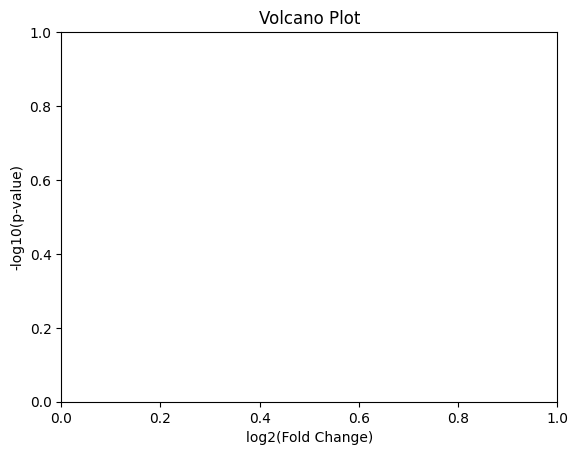

In [24]:
import matplotlib.pyplot as plt
from visualizations import ScatterPlotToolkit
q = ScatterPlotToolkit(title = 'Volcano Plot') # x and y labels pre-defined to apply for volcano plot, but can be easily modified
q.set_size((10,10))
q.set_axes((-20,20),(-10,70))
q.set_significance_lines(threshold_p=0.05,threshold_FC=(-2,2))
q.plot(final_processed_df,'log2FoldChange','-log10(p-value)')
q.color_by(final_processed_df,'log2FoldChange','-log10(p-value)',color_by='significance')
q.label_genes(top_genes,'log2FoldChange','-log10(p-value)','row')
plt.savefig("volcano_plot.png", format='png', dpi=300)
plt.show()

The `RNABarPlotter` Class is used to display the expression change level and direction in a vertical bar plot.
The following code outputs a visualization of the **log2FoldChange** of selected genes (selected genes are chosen by `Cleaner` class).

In [3]:
from visualizations import RNABarPlotter

bar_plot = RNABarPlotter(cleaned_data)
bar_plot.plot(0.05)

ModuleNotFoundError: No module named 'data_visualizations'

Lets assume that we are intereseted only in protein coding genes.  
The following code will allow to filter out genes that are not protein coding, according to ensemble database.

In [7]:
from filter_protein_coding_genes import *

protein_coding_genes = download_protein_coding_genes()
cleaned_data = filter_protein_coding_genes(cleaned_data, protein_coding_genes)

cleaned_data


As is visible in the above table, the 'related pathway' column was added, with values related to each gene with relatively 'general' pathway.  
If, however, one is interested in more specific pathways that each gene is part of,  
it is possible to use another function, named `enrich_gene()`, that will provide greater detail for each gene.  
This function is relies on blabla python library, which has access to a wide range of databases.

In [8]:
from concurrent.futures import ThreadPoolExecutor 
from DataProcessing_PythonLibraries import *

with ThreadPoolExecutor(max_workers=8) as executor:  
    related_pathways = list(executor.map(enrich_gene, cleaned_data['row']))

cleaned_data['related pathways'] = related_pathways

#num of gene with path and num of errors 
genes_with_pathways = cleaned_data[(cleaned_data['related pathways'] != 'No related pathways found') & (df_cleaned['related pathways'] != 'Error during enrichment')]
count_genes_with_pathways = genes_with_pathways.shape[0]
errors= cleaned_data[cleaned_data ['related pathways'] == 'Error during enrichment']
count_errors=errors.shape[0]

cleaned_data

/Users/zivbentulila/anaconda3/envs/python_lab_course/lib/python3.11/site-packages/gseapy/enrichr.py:643: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.results = pd.concat(self.results, ignore_index=True)
/Users/zivbentulila/anaconda3/envs/python_lab_course/lib/python3.11/site-packages/gseapy/enrichr.py:643: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.results = pd.concat(self.results, ignore_index=True)
/Users/zivbentulila/anaconda3/envs/python_lab_course/lib/python3.11/site-packages/

KeyboardInterrupt: 

More information about all the functions shown in this example are shown in the DOCSTRING for each function.